# Introduction and Overview of existing gradient algorithms

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antonAce/improved-computer-vision/blob/master/notebook/benchmark.ipynb)

In this assignment, we explore the evolution and significance of gradient descent algorithms, focusing on their applications in handling complex data-driven problems prevalent in fields such as machine learning and natural language processing. We will delve into the foundations of both classical and adaptive stochastic gradient techniques and investigating their convergence properties.

### Historical Context

Gradient descent algorithms have evolved significantly, starting from the stochastic approximation methods of Kiefer-Wolfowitz and Robbins-Monro in the 1950s, to the introduction of advanced techniques like Momentum Gradient Descent and Nesterov's accelerated method in the 1980s. The 2010s marked a shift towards adaptive methods, with algorithms like AdaGrad, RMSProp, and ADAM, each bringing unique approaches to learning rate adjustments and showcasing effectiveness in various applications, particularly in deep learning.

### Learning Objectives

1. Understand the fundamental concepts of gradient, gradient descent, and stochastic optimization;
2. Explore the theoretical foundations and practical applications of various stochastic gradient descent algorithms;
3. Compare the performance of different gradient descent algorithms on a test convex and smooth objective function.

## Prerequisites

Before delving into the implementation and comparison of gradient descent algorithms, it is essential to set up the necessary computational environment. We will be utilizing the PyTorch library to perform all calculations, as it offers a flexible and efficient platform for scientific computing, particularly in machine learning.

In [2]:
# Import the PyTorch library
import torch

# Import typing annotations for assignment hints
from typing import Callable, Tuple

# Check the version of PyTorch
print("PyTorch Version:", torch.__version__)

# Perform a basic operation to test PyTorch
a = torch.tensor([1.0, 2.0])
b = torch.tensor([3.0, 4.0])

# Assert the result of the sum
assert torch.equal(a + b, torch.tensor([4.0, 6.0])), "The sum of a and b is incorrect!"

PyTorch Version: 2.0.1+cu118


### Algorithm convergence visualisation

Iterations of the each gradient descent algorithm can be plotted as the path on 3D surface, in case model has only 2 independent parameters $\{ \theta_{1}, \theta_{2} \}$ so they can represent $X$ and $Y$ axises, and remaining $Z$ axis represents value of estimation equation to optimize $J(\theta_{1}, \theta_{2})$. All visualisation tools are used from [matplotlib](https://github.com/matplotlib/matplotlib) package.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import matplotlib.cm as colormaps
from matplotlib import rcParams, cycler

from mpl_toolkits.mplot3d.axes3d import Axes3D

To plot the projection of the 3D surface of $J(\theta_{i})$ will be used a custom procedure.

In [4]:
def plot_grid(F: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
              X: torch.Tensor, Y: torch.Tensor,
              elev: int = 30, azim: int = 50, ax=None) -> Axes3D:
  """
  Plots 3D surface grid for 2 independent parameters and estimation equation.

  Args:
      F (Callable[[torch.Tensor, torch.Tensor], torch.Tensor]): Estimation equation.
      X (torch.Tensor): First independent parameter.
      Y (torch.Tensor): Second independent parameter.
      elev (int, optional): Vertical rotation angle. Defaults to 30.
      azim (int, optional): Horizontal rotation angle. Defaults to 50.
      ax (Axes3D, optional): Predefined plotting axis. If None, a new one will be created. Defaults to None.

  Returns:
      Axes3D: Generated plotting axis for potential reusability.
  """

  # Generating grid
  x, y = torch.meshgrid(X, Y, indexing='xy')

  # If grid plotting axis is not defined above, the new one will be created
  if ax is None:
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.view_init(elev=elev, azim=azim)

  # Plotting grid
  surf = ax.plot_surface(x.numpy(), y.numpy(), F(x, y).numpy(),
                          cmap=colormaps.coolwarm,
                          antialiased=True)
  fig.colorbar(surf)

  # For axis reusability purposes
  return ax

## Stochastic Optimization Problem

Stochastic optimization problems form the bedrock for addressing uncertainties and randomness inherent in various domains like finance, machine learning, and operations research. Contrasting with deterministic optimization, where the objective function and constraints are well-defined, stochastic optimization introduces challenges by incorporating components that exhibit randomness. In this section, we delve into the mathematical formulation of a stochastic optimization problem and explore how stochastic gradient descent algorithms tackle the challenges presented by this formulation.

### Mathematical Formulation

Given an objective function $ f: X \to \mathbb{R} ^ n $ with domain $ X \subset \mathbb{R} ^ n $, and a convex and differentiable function $ F: X \times \Xi \to \mathbb{R} ^ 1 $ that depends on the determined variable $ x \in X $ and a stochastic variable $ \xi \in \Xi $, defined on a space $ (\Xi, \Sigma, P) $, a stochastic optimization problem can be represented as:

$$
\min_{x \in X} \left[f(x) = \mathbb{E} F(x, \xi) = \int_{\xi \in \Xi} F(x, \xi) P(d \xi), X \subset \mathbb{R} ^ n\right]
$$

Here, $ \mathbb{E} $ denotes the mathematical expectation. The intrinsic challenge of this problem lies in the difficulty of explicitly calculating the value of an integral (mathematical expectation) and the gradient of this integral. Stochastic gradient descent algorithms, leveraging gradients $ \nabla_{x} F(x, \xi) $ of a stochastic function $ F(\cdot, \xi) $ or their finite-difference counterparts, offer a solution to this challenge.

### Practical Implications

These optimization problems are pivotal in scenarios where decision-making is dependent on incomplete or uncertain information. Employing techniques such as random sampling, Monte Carlo simulations, and stochastic gradients, stochastic optimization methods effectively and efficiently traverse the optimization landscape, aiming for convergence to the optimal solution.

### Stochastic logistic regression

Logistic regression is chosen as an example of an optimization problem for comparing the convergence rate of the gradient descent algorithms. This mathematical model can be described as a binary classifier, which outputs a probability value of a certain set of features $ x_{i} $ to belong to a certain class. Using the definition of optimization problem from above, the classifier can be represented in the form of two components: an adder that combines all the characteristics into a single one: $ z_{j} = \sum_{i=1}^{n} \theta_{i} x_{i, j} + \varepsilon $ (or $ z_{j} = \theta^{T} \cdot x + \varepsilon $), and a converter that calculates the probability of the characteristics belonging to a certain class based on the output value of an adder: $g(a) = \frac{1}{1 + e^{-a}}$. Here $ \varepsilon \simeq N(0, 1) $ is a stochastic parameter in the model.

In [5]:
def adder_fn(theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return theta.t() @ x

def converter_fn(a: torch.Tensor) -> torch.Tensor:
    return 1.0 / (1.0 + torch.exp(-a))

# x = (0, 0), theta = (1, 1) => g = 0.5
assert torch.allclose(
    converter_fn(adder_fn(torch.tensor([[1.0], [1.0]]),
                          torch.tensor([[0.0], [0.0]]))),
    torch.tensor([[0.5]]))

# x = (1, 0), theta = (1, 1) => g = 0.7310586
assert torch.allclose(
    converter_fn(adder_fn(torch.tensor([[1.0], [1.0]]),
                          torch.tensor([[1.0], [0.0]]))),
    torch.tensor([[0.7310586]]))

# x = (0, -1), theta = (1, 1) => g = 0.26894143
assert torch.allclose(
    converter_fn(adder_fn(torch.tensor([[1.0], [1.0]]),
                          torch.tensor([[0.0], [-1.0]]))),
    torch.tensor([[0.26894143]]))

# x = (0.5, -1), theta = (2, -1.5) => g = 0.9241418
assert torch.allclose(
    converter_fn(adder_fn(torch.tensor([[2.0], [-1.5]]),
                          torch.tensor([[0.5], [-1.0]]))),
    torch.tensor([[0.9241418]]))

The solution to the problem is to find optimal $\theta_{i}$ so for input features $x_{i}$ the loss $J(\theta_{i})$ between output value of classifier $\hat{y_{j}} = g(z_{\theta}(x_{i, j}))$ and expected value $y_{j}$ will be minimal.

The set of classes, mentioned above, can be represented as $\{ 0, 1 \}$, e. g. if model output is $1$ - features belong to the class, and if $0$ - features do not belong to the class. In this case, the rule of the fitting regression model can be interpreted as follows: *if expected output is $y=1$, the loss should approach $0$ when model output approaches $1$ and grow to infinity when model output approaches $0$. For the case $y=0$ these conditions apply vise versa.*

Model fitting rule or loss function can expressed as limits:

$\begin{cases}
\lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = 0, & \lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = \infty, & y=1 \\
\lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = 0, & \lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = \infty, & y=0
\end{cases}$

Limitation conditions fit the $\log(x)$ function, so the loss function can be expressed as the following system:

$ J_{j}(g, y) = \begin{cases}
-\log(g), & y = 1  \\
-\log(1 - g), & y = 0
\end{cases}$

The statement can be joined into a single formula: $ J_{j}(g, y) = - y \log(g) - (1 - y) \log(1 - g) $ - this formula is appliable for single pair of features and output. For multiple pairs loss value can be calculated as the mean of losses for single pairs: $ J(g, y) = \frac{1}{m} \sum_{j=1}^{m} J_{j}(g, y) = \frac{1}{m} \sum_{j=1}^{m} ( - y \log(g) - (1 - y) \log(1 - g) ) = -\frac{1}{m} \sum_{j=1}^{m} (y \log(g) + (1 - y) \log(1 - g) )$

In [6]:
def loss_fn(g: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Computes the binary cross-entropy loss between predicted probabilities and target labels.

    Args:
    g (torch.Tensor): The predicted probabilities.
    y (torch.Tensor): The target labels.

    Returns:
    torch.Tensor: The computed binary cross-entropy loss.
    """

    return -y * torch.log(g) - (1 - y) * torch.log(1 - g)

As the result, the derived fitting rule (loss function) is a convex function with only one minimum for each output class $ \{ 0, 1 \} $. This can be demonstraited on the following plots:

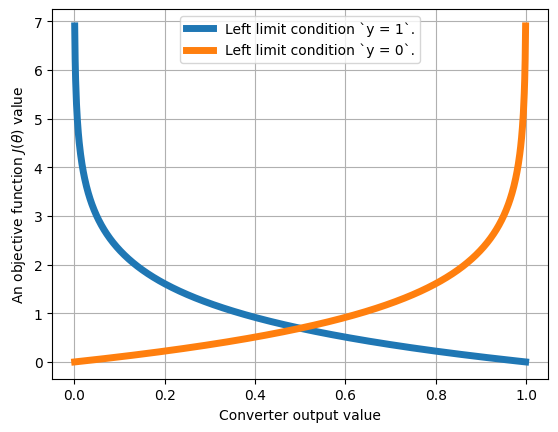

In [7]:
# Generate an array of values
g = torch.arange(0.001, 1.0, 0.001)

# Compute JLeft and JRight
loss_left = -torch.log(g)
loss_right = -torch.log(1 - g)

# Plotting
plt.plot(g.numpy(), loss_left.numpy(), lw=5, label='Left limit condition `y = 1`.')
plt.plot(g.numpy(), loss_right.numpy(), lw=5, label='Left limit condition `y = 0`.')
plt.xlabel('Converter output value')
plt.ylabel(r'An objective function $ J(\theta) $ value')
plt.grid(True)
plt.legend(loc='upper center')

plt.show()

The loss function is formed from combined limit conditions, which is plotted as a diagonal cross-section of the grid below:

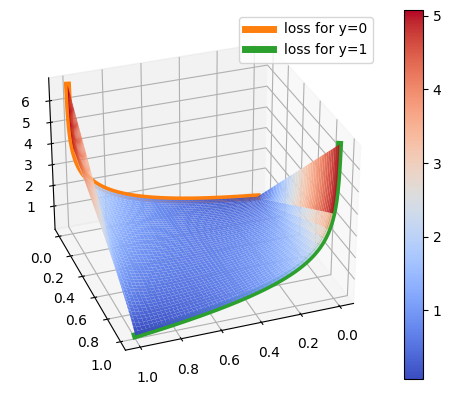

In [8]:
# Create a tensor y, ranging from 0.001 to 1.0 with steps of 0.001
y = torch.arange(0.001, 1.0, 0.001)

# Arguments for output equals 0
yleft = torch.zeros(y.shape[0])

# Arguments for output equals 1
yright = torch.ones(y.shape[0])

# Loss function plot in 3D cross-section
ax = plot_grid(loss_fn, g, y, elev=30, azim=70)

# Loss function plot for output equals 0
ax.plot(g.numpy(), yleft.numpy(), loss_fn(g, yleft).numpy(), lw=5, label="loss for y=0")

# Loss function plot for output equals 1
ax.plot(g.numpy(), yright.numpy(), loss_fn(g, yright).numpy(), lw=5, label="loss for y=1")

plt.legend()
plt.show()

Loss calculation test cases:

In [9]:
assert torch.allclose(
    loss_fn(torch.tensor([0.0001]), torch.tensor([0.0])),
    torch.tensor([0.00010002]))

assert torch.allclose(
    loss_fn(torch.tensor([0.9998]), torch.tensor([1.0])),
    torch.tensor([0.00019999]))

assert torch.allclose(
    loss_fn(torch.tensor([0.8]), torch.tensor([0.0])),
    torch.tensor([1.609438]))

assert torch.allclose(
    loss_fn(torch.tensor([0.2]), torch.tensor([1.0])),
    torch.tensor([1.609438]))

### Training dataset

Necessary requirements for a set of training examples are:
- Expected outputs should belong only to binary classes, e. g. $\hat{y_{j}} \in \{ 0, 1 \}$;
- Input features should be defined as rational values $ \{ x_{ij} | x_{ij} \in R \} $;

For simplicity, a set of a training examples will be generated as feed-forward of regression model $g(z_{\theta}(\hat{\theta_{i}}, x_{i, j}))$

In [16]:
import torch

# To generate same random numbers per each run.
torch.manual_seed(0)

# Mean, variance and count of training examples
mu, sigma, n = 0.0, 1.0, 50

# Random noise
e = torch.normal(mean=mu, std=sigma, size=(n,))

# Mean value of the parameters
theta = torch.tensor([2.0, 1.0])

# Randomly distributed input features
x_ = 4.0 * torch.rand((2, n)) - 2.0

# Output labels as a direct feed-forward result
y_ = 1.0 / (1.0 + torch.exp(-(theta @ x_)))

# Expected output labels, use it as an output in the algorithms implementation
y = torch.round(y_)

# Input features with random noise, use it as an input in the algorithms implementation
x = x_ + e

### Gradient approximation

While libraries like PyTorch offer automatic differentiation, this assignment encourages a hands-on approach. We will be utilizing the second-order accurate central differences method to estimate gradients, offering insight into the intricacies of gradient computation and its role in optimization algorithms.

We can derive approximation formula from the Taylor's series polynomial while discarding unnecessary residual terms that have higher accuracy order than the first order:

$$ f(x_0 + h) = f(x_0) + f'(x_0)(h) + o(h) $$

By applying finite differences approximation we get left and right finite differences:

$$
\begin{cases}
  f'_{-}(x) = \frac{f(x + h) - f(x)}{h} - \frac{h f''(\xi)}{2} \\
  f'_{+}(x) = \frac{f(x) - f(x - h)}{h} + \frac{h f''(\xi)}{2}
\end{cases}
$$

The accuracy of the approximation depends on the number of nodes on the numerical partitioning grid, thus the smaller step difference, the higher precision. Using the Runge-Romberg-Richardson algorithm we can achieve an increase in the order of the precision of the partitioning grid up to $ O(h^2) $ without adding extra iterations to the approximation algorithm:

$$
\begin{cases}
  f'_{-}(x) = \frac{-3 f(x) + 4 f(x + h) - f(x + 2h)}{2h} + \frac{h^2 f'''(\xi)}{3} \\
  f'(x) = \frac{f(x + h) - f(x - h)}{2h} + \frac{h^2 f'''(\xi)}{6} \\
  f'_{+}(x) = \frac{f(x - 2h) - 4 f(x - h) + 3 f(x)}{2h} + \frac{h^2 f'''(\xi)}{3}
\end{cases}
$$

The approach of approximating the gradient value of the target function with a finite-difference schema lets us generalize optimization problems on any kind of analytical functions.

In [13]:
def grad_left(F: Callable[[torch.Tensor], torch.Tensor], x: torch.Tensor, h: float = 0.001) -> torch.Tensor:
  """A finite-difference approximation for left-side gradient ∇F₋(x) with the precision order O(h^2).

  Args:
      F (Callable[[torch.Tensor], torch.Tensor]): an objective function F(x) with a single input argument x ∈ ℝⁿ.
      x (torch.Tensor): an input vector x ∈ ℝⁿ, where the derivative is calculated.
      h (float, optional): a step of the derivative partitioning grid with the range of 0<h<1. The lower value, the higher gradient precision. Defaults to 0.001.

  Returns:
      torch.Tensor: a gradient vector approximation ∇F₋(x).
  """

  n = x.shape[0]
  grad = torch.zeros_like(x)

  for i in range(n):
      vh = h * torch.eye(n)[i]
      grad[i] = (-3*F(x) + 4*F(x + vh) - F(x + 2*vh)) / (2. * h)

  return grad


def grad_center(F: Callable[[torch.Tensor], torch.Tensor], x: torch.Tensor, h: float = 0.001) -> torch.Tensor:
  """A finite-difference approximation for central gradient ∇F(x) with the precision order O(h^2).

  Args:
      F (Callable[[torch.Tensor], torch.Tensor]): a target function F(x) with a single input argument x ∈ ℝⁿ.
      x (torch.Tensor): an input vector x ∈ ℝⁿ, where the derivative is calculated.
      h (float, optional): a step of the derivative partitioning grid with the range of 0 < h < 1. The lower value, the higher gradient precision. Defaults to 0.001.

  Returns:
      torch.Tensor: a gradient vector approximation ∇F(x).
  """

  n = x.shape[0]
  grad = torch.zeros_like(x)

  for i in range(n):
      vh = h * torch.eye(n)[i]
      grad[i] = (F(x + vh) - F(x - vh)) / (2.0 * h)
  return grad


def grad_right(F: Callable[[torch.Tensor], torch.Tensor], x: torch.Tensor, h: float = 0.001) -> torch.Tensor:
  """A finite-difference approximation for right-side gradient ∇F+(x) with the precision order O(h^2).

  Args:
      F (Callable[[torch.Tensor], torch.Tensor]): a target function F(x) with a single input argument x ∈ ℝⁿ.
      x (torch.Tensor): an input vector x ∈ ℝⁿ, where the derivative is calculated.
      h (float, optional): a step of the derivative partitioning grid with the range of 0<h<1. The lower value, the higher gradient precision. Defaults to 0.001.

  Returns:
      torch.Tensor: a gradient vector approximation ∇F+(x).
  """

  n = x.shape[0]
  grad = torch.zeros_like(x)

  for i in range(n):
      vh = h * torch.eye(n)[i]
      grad[i] = (F(x - 2*vh) - 4*F(x - vh) + 3*F(x)) / (2. * h)

  return grad

We will check the accuracy of the implemented method on the test case:

$ F(x, y) = x^2 + xy + y^2 \implies \begin{cases} \frac{\partial F(x, y)}{\partial x} = 2x + y, \frac{\partial F(2.0, -1.0)}{\partial x} = 3.0 \\ \frac{\partial F(x, y)}{\partial y} = x + 2y, \frac{\partial F(2.0, -1.0)}{\partial y} = 0.0
 \end{cases} $

In [15]:
h = 0.001
x = torch.tensor([2.0, -1.0])
f = lambda x: x[0] ** 2 + x[0] * x[1] + x[1] ** 2

assert torch.allclose(grad_left(f, x, h=h), torch.tensor([3.0, 0.0]), atol=h)
assert torch.allclose(grad_center(f, x, h=h), torch.tensor([3.0, 0.0]), atol=h)
assert torch.allclose(grad_right(f, x, h=h), torch.tensor([3.0, 0.0]), atol=h)

## Gradient descent variations

Gradient descent algorithms have a common feature: using calculated gradient value as a direction towards the minimum of the function. The gradient value, by definition, is a vector that points towards the direction of the greatest increase of the function in a specific point. So the value, opposite to the gradient value or $ - \nabla_{\theta} J $, points towards the minimum.

In general, gradient descent algorithm can be expressed as an iterative algorithm, that on each step $ \theta_{j}^{(i)} $ moves in direction of $ - \nabla_{\theta} J $ with a fixed size step $ \lambda $ (also known as learning rate) untill it reaches the minimum: $\theta_{j}^{(i+1)} = \theta_{j}^{(i)} - \lambda \nabla_{\theta} J$.

The well-known analogy of the algorithm in real world is a ball, rolling down the hill. In this case the gradient value $ - \nabla_{\theta} J $ representes rolling direction and learning rate $ \lambda $ - the speed.

Depending on how much data is used to compute the gradient of objective function, general form of an algorithm can variate, which leads to the possibility for a trade-off between the accuracy of the parameter update and the time it takes to perform an update.

In [17]:
def objective_function(_theta: torch.Tensor) -> torch.Tensor:
  return loss_fn(converter_fn(adder_fn(_theta, x)), y)

### Batch gradient descent

Batch gradient descent or vanilla gradient descent performs computation of the gradient for $ \nabla_{\theta} J $ with respect to the independent variables $ \theta_{j} $ for the entire set of training examples: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta, x, y)$

Although batch gradient descent is guaranteed to converge to the global
minimum for convex noisy surfaces, it requires to calculate gradient value for the entire set training examples, which makes it unefficient to calculate in parallel and, as the result, makes it very slow, because it can not update model parameters "on-the-fly". Another issue with this algorithm is an eager usage of memory, which means loading every training example into memory.

Vanilla GD performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update, so its usage is efficient on a relatively small datasets.

According to the original paper, BGD is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

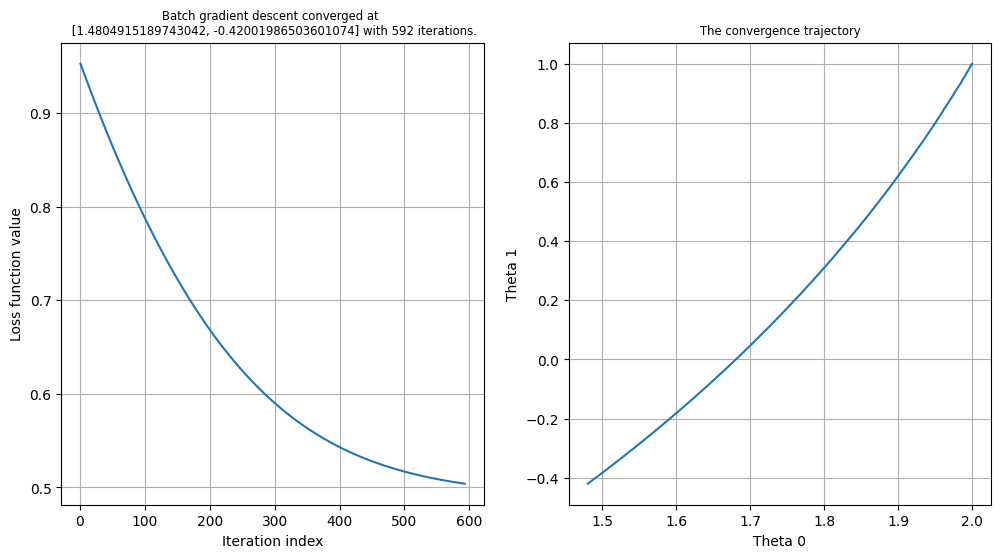

In [18]:
def batch_loss(_theta: torch.Tensor) -> torch.Tensor:
  return torch.sum(objective_function(_theta)) / torch.tensor([n])


eps = 0.001 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.01]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $

loss_hist = []
theta_bgd_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_bgd = theta.detach().clone()

for epoch in range(max_epoch):
  loss_hist.append(batch_loss(theta_bgd).detach().numpy().item())
  grad_val = grad_center(batch_loss, theta_bgd) # TODO: Check other estimators and compare iterations number
  theta_bgd -= alpha * grad_val

  theta_bgd_hist = torch.cat((theta_bgd_hist, torch.reshape(theta_bgd, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_bgd_hist[-1] - theta_bgd_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist) + 1)), loss_hist)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'Batch gradient descent converged at \n {theta_bgd.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_bgd_hist[:, 0], theta_bgd_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

### Stochastic gradient descent

Unlike algorithm from above, stochastic gradient descent (SGD) calculates gradient and performs parameters update for a single training example at once $( x_{i1}, ..., x_{in}, y_{i} ) $, where $ x_{i1}, ..., x_{in} $ are input features of a training example and $ y_{i} $ - label a training example: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)})$

SGD removes redundancy for recomputing gradients for similar examples before each parameter update and also provides a possibility for a parallel computation of the gradient value for each example, which leads to updating model parameters "on-the-fly" (which lead to the faster computation).

Nevertheless, this approach has its own flaw: frequent updates with a high variance that cause the objective function to fluctuate heavily On the one hand, SGD's fluctuation enables it to jump to a new and potentially better (global) minimum in a process of descending to the other local minimum. But on the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting. In practice, this flaw can be solved using learning rate decay methods (e. g. rate decreasing over epoch/iteration), though it requires precise parameter tuning.

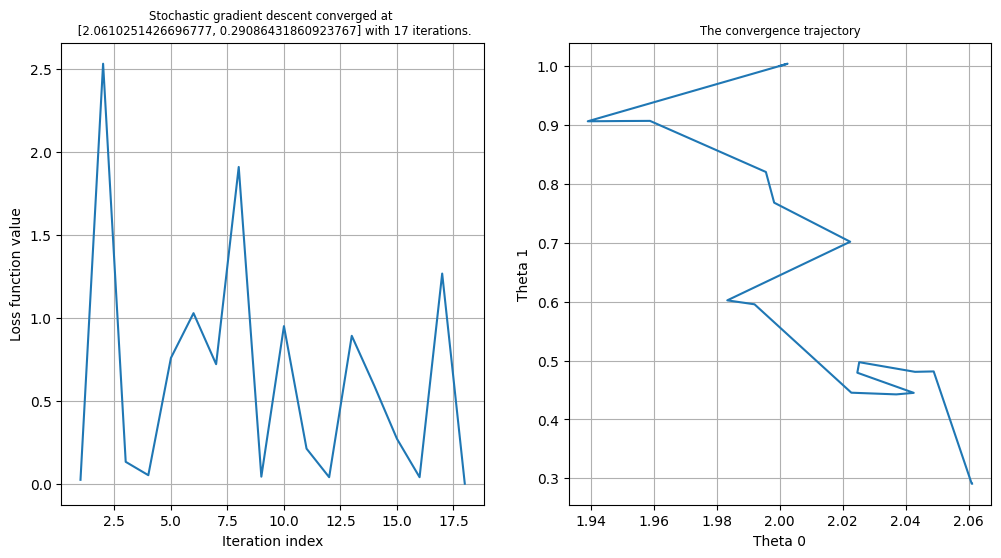

In [19]:
def sgd_loss_generator(x: torch.Tensor, y: torch.Tensor):
  def func(_theta: torch.Tensor):
    return loss_fn(converter_fn(adder_fn(_theta, x)), y)
  return func

eps = 1e-3 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.1]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $

loss_hist_sgd = []
theta_sgd_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_sgd = theta.detach().clone()

size = y.shape[0]
for epoch in range(max_epoch):
  i = epoch % size
  sgd_x = x[:, i, None]
  sgd_y = y[i]
  loss = sgd_loss_generator(sgd_x, sgd_y)

  loss_hist_sgd.append(loss(theta_sgd).detach().numpy().item())
  grad_val = grad_center(loss, theta_sgd)
  theta_sgd -= alpha * grad_val

  theta_sgd_hist = torch.cat((theta_sgd_hist, torch.reshape(theta_sgd, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_sgd_hist[-1] - theta_sgd_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_sgd) + 1)), loss_hist_sgd)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'Stochastic gradient descent converged at \n {theta_sgd.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_sgd_hist[:, 0], theta_sgd_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

### Mini-batch gradient descent

Mini-batch gradient descent is the golden ratio between BGD and SGD, because it inherits the best features from both algorithms. It performs an update for an every subset of training examples of a fixed size $m$:

$\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(j, j + m)}, ..., x_{n}^{(j, j + m)}, y^{(j, j + m)})$

In this approach, the variance of the parameter updates is significantly reduced, which make converge of the algorithm more stable

Although, this algorithm is a combination of the best features of BGD and SGD, it's not flawless. Mini-batch GD requires precised tuning of the learning rate (if it's too small - converge speed will significantly decrease, if it's too large - the loss function will fluctuate around minimum and, as a result, it will hinder convergence) and the algorithm not effective with noisy and highly non-convex functions, so the chance of being trapped in local minimum is bigger, than in other algorithms.

As was shown in the original paper, there are other major challenges, that may occur:
 - The learning rate requires scheduling in order to make the algorithm reach the optimal point. The scheduler adjust it during training (by reducing the learning rate according to a pre-defined value or when the change in objective between epochs falls below a threshold);
 - The algorithm is not effective on sparse data (when features have different frequencies), because the same learning rate applies to all parameter updates;
 - The more saddle point function $J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)})$ have, the less effective algorithm becomes;

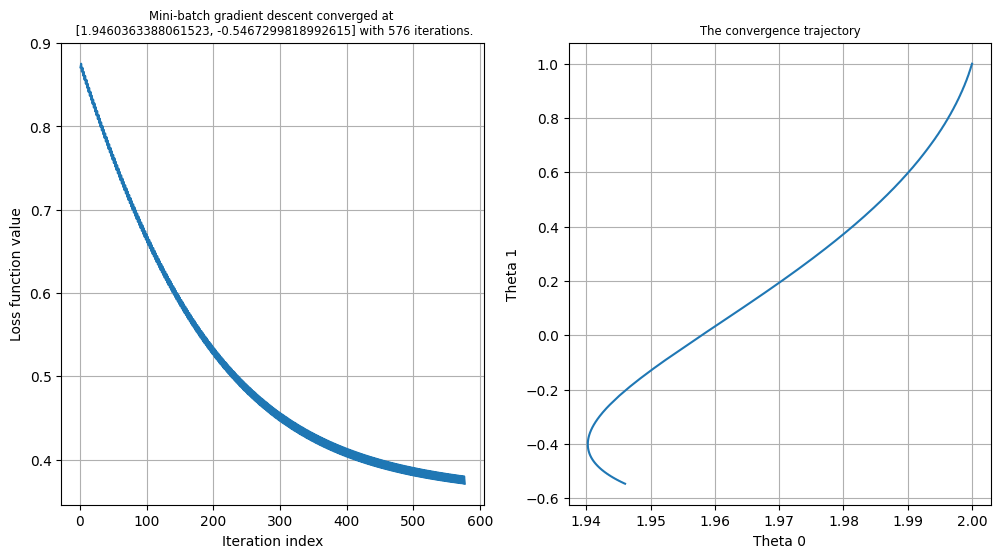

In [20]:
import math

def mgd_loss_generator(x: torch.Tensor, y: torch.Tensor):
  def func(_theta: torch.Tensor):
    loss = loss_fn(converter_fn(adder_fn(_theta, x)), y)
    reduced = torch.sum(loss) / y.size(0)
    return reduced
  return func


def get_sample(idx: int, batch_size: int):
  y_mgd = y[idx:idx+batch_size]
  x_mgd = x[:, idx:idx+batch_size]
  return x_mgd, y_mgd


eps = 1e-3 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1_000
alpha = torch.tensor([0.01]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $

loss_hist_mgd = []
theta_mgd_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_mgd = theta.detach().clone()

BATCH_SIZE = 25

size = y.size(0)
num_batches = math.ceil(size / BATCH_SIZE)
for epoch in range(max_epoch):
  i = epoch % num_batches

  x_mgd, y_mgd = get_sample(i, BATCH_SIZE)
  loss = mgd_loss_generator(x_mgd, y_mgd)

  loss_hist_mgd.append(loss(theta_mgd).detach().numpy().item())
  grad_val = grad_center(loss, theta_mgd)
  theta_mgd -= alpha * grad_val

  theta_mgd_hist = torch.cat((theta_mgd_hist, torch.reshape(theta_mgd, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_mgd_hist[-1] - theta_mgd_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_mgd) + 1)), loss_hist_mgd)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'Mini-batch gradient descent converged at \n {theta_mgd.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_mgd_hist[:, 0], theta_mgd_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

SGD's variating descent, BGD's smooth descent, and MGD's moderate descent can be visualized on the comparison of loss function values over iterations and epochs accordingly.

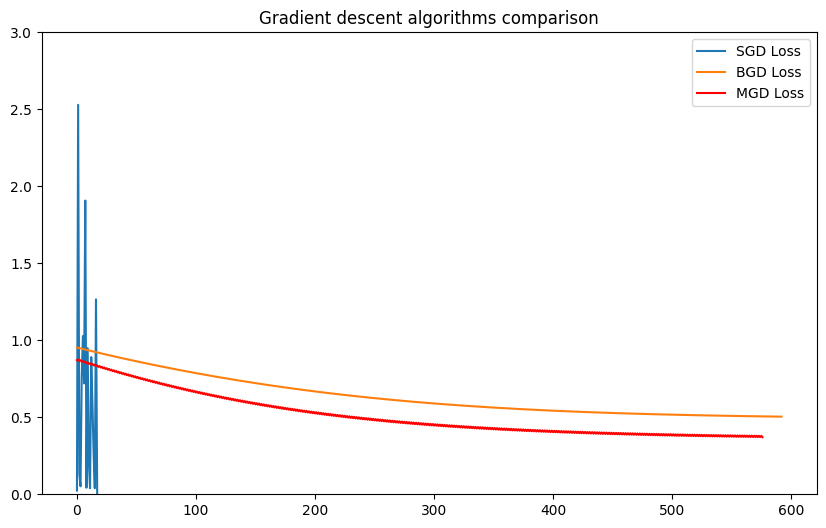

In [21]:
fig = plt.figure(figsize=(10, 6))

plt.plot(loss_hist_sgd, label='SGD Loss')
plt.plot(loss_hist, label='BGD Loss')
plt.plot(loss_hist_mgd, 'r', label='MGD Loss')
plt.ylim(0, 3)
plt.title('Gradient descent algorithms comparison')
plt.legend()
plt.show()

## Accelerated gradient descent methods

As was highlighted before, the common problems of the vanilla gradient descent variations are **learning rate tuning** and loss function fluctuations (for SGD and MGD). The recent researches in GD algorithms shown, that these problems can be solved and the convergence rate can be increased by using adaptive gradient calculation, which means applying gradient values from previous iterations to adjust the current one.

### Momentum

Returning back to the analogy of gradient descent algorithm as a ball, rolling down the hill, important to mention that it's not rolling with a constant speed $ \lambda $, but instead gaining speed with time by keeping the momentum of itself. The same approach was discovered in optimization theory: the convergence rate of an algorithm can be increased by applying a fraction $ \gamma $ of gradient from the previous iteration:

$ v_{t} = \gamma v_{t-1} + \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{t} $

The momentum term $ \gamma $ is usually set to 0.9 or a similar value.

As mentioned in previous sections, SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around the local minimum. Momentum helps accelerate SGD in the relevant direction and dampens oscillations.

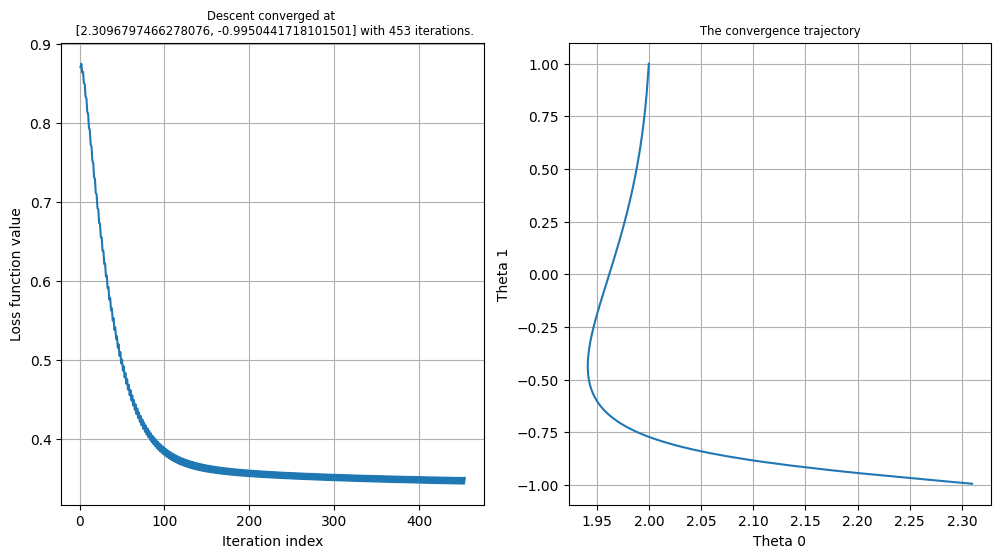

In [22]:
def mgd_loss_generator(x: torch.Tensor, y: torch.Tensor):
    def func(_theta: torch.Tensor):
        loss = loss_fn(converter_fn(adder_fn(_theta, x)), y)
        reduced = torch.sum(loss) / y.size(0)
        return reduced
    return func

def get_sample(idx: int, batch_size: int):
    y_mgd = y[idx:idx+batch_size]
    x_mgd = x[:, idx:idx+batch_size]
    return x_mgd, y_mgd


eps = 0.001 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.01]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $
gamma = torch.tensor([0.8]) # A momentum term

loss_hist_momentum = []
theta_momentum_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_momentum = theta.detach().clone()
velocity = torch.zeros_like(theta_sgd)

BATCH_SIZE = 25

size = y.shape[0]
num_batches = math.ceil(size / BATCH_SIZE)
for epoch in range(max_epoch):
  i = epoch % num_batches
  x_mgd, y_mgd = get_sample(i, BATCH_SIZE)
  loss = mgd_loss_generator(x_mgd, y_mgd)

  loss_hist_momentum.append(loss(theta_momentum).detach().numpy().item())
  grad_val = grad_center(loss, theta_momentum)

  velocity = gamma * velocity + alpha * grad_val

  theta_momentum -= velocity


  theta_momentum_hist = torch.cat((theta_momentum_hist, torch.reshape(theta_momentum, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_momentum_hist[-1] - theta_momentum_hist[-2]) < eps:
    break


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_momentum) + 1)), loss_hist_momentum)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'Descent converged at \n {theta_momentum.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_momentum_hist[:, 0], theta_momentum_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

### Nesterov accelerated gradient

In this approach, the momentum is not only applied to the calculated gradient value on the iteration, but also to the current parameters, which gives an approximation of their next position, like a preliminary step of the algorithm:

$ v_{i} = \gamma v_{i-1} + \lambda \nabla_{\theta} J(\theta^{(i)} - \gamma v_{i-1}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{i} $

Taking the analogy from above, if a ball is made of light material, it may slope up to the other side of a hill using its momentum. But if it is made of heavy material (like steel), it will slow down near the bottom of the hill. The NAG algorithm work by the same principle. While momentum first computes the current gradient and then takes a big jump in the direction of the updated accumulated gradient, NAG first makes a big jump in the direction of the previously accumulated gradient, measures the gradient, and then makes a correction. This anticipatory update prevents us from going too fast and results in increased responsiveness.

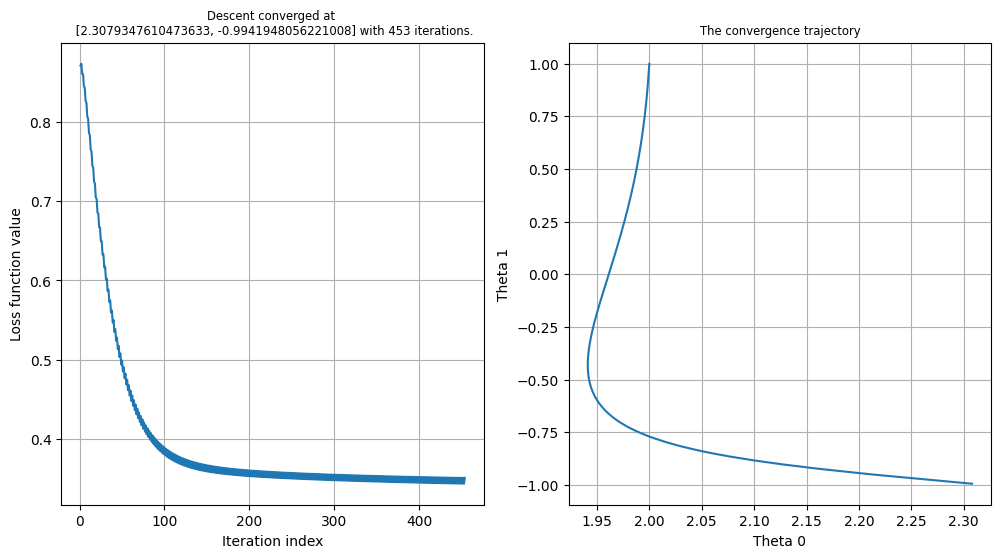

In [23]:
import math

def mgd_loss_generator(x: torch.Tensor, y: torch.Tensor):
    def func(_theta: torch.Tensor):
        loss = loss_fn(converter_fn(adder_fn(_theta, x)), y)
        reduced = torch.sum(loss) / y.size(0)
        return reduced
    return func

def get_sample(idx: int, batch_size: int):
    y_mgd = y[idx:idx+batch_size]
    x_mgd = x[:, idx:idx+batch_size]
    return x_mgd, y_mgd

eps = 0.001
h = 0.0001
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.01])
gamma = torch.tensor([0.8])  # Momentum term

loss_hist_nag = []
theta_nag_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_nag = theta.detach().clone()
velocity = torch.zeros_like(theta_sgd)

BATCH_SIZE = 25

size = y.shape[0]
num_batches = math.ceil(size / BATCH_SIZE)
for epoch in range(max_epoch):
    i = epoch % num_batches
    x_mgd, y_mgd = get_sample(i, BATCH_SIZE)

    # Calculate the lookahead parameters
    lookahead_theta = theta_nag - gamma * velocity
    loss = mgd_loss_generator(x_mgd, y_mgd)

    loss_hist_nag.append(loss(lookahead_theta).detach().numpy().item())
    grad_val = grad_center(loss, lookahead_theta)

    velocity = gamma * velocity + alpha * grad_val
    theta_nag -= velocity

    theta_nag_hist = torch.cat((theta_nag_hist, torch.reshape(theta_nag, (1, theta.shape[0]))), dim=0)

    if torch.norm(theta_nag_hist[-1] - theta_nag_hist[-2]) < eps:
        break


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_nag) + 1)), loss_hist_nag)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'Descent converged at \n {theta_nag.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_nag_hist[:, 0], theta_nag_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

## Gradient methods with adaptive learning rate

In the previous modification of **SGD**, the learning rate $ \lambda $ was fixed in size, so the problem with tuning it is still relevant to avoid either slow convergence or complete diverge. The following method modifications tend to solve this major issue.

### AdaGrad

The AdaGrad algorithm adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters: given learning rate $ \lambda $ value is divided on some term $ G_{i} $ that accumulates gradient values from previous iterations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{G_{i} + \epsilon}} \odot g_{i} $, where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a smoothing term (a small coefficient, usually equals $ 3 \cdot 10^{-6} $, that prevents the denominator from turning to zero) and  $ G_{i} $ is a combination of the previously accumulated gradient terms and element-wise product of $ g_{i} $ on itself: $ G_{i} = G_{i-1} + g_{i} \cdot g_{i} = G_{i-1} + (g_{i})^{2} $

Although the mentioned problem with tuning learning rate $ \lambda $ is solved (in practice, the value is set to default 0.01 and left like that), the new one appears: accumulation of the squared gradients in the denominator causes $ \lambda $ to shrink with every iteration (since every term is positive) and eventually is approaching zero. It can be illustrated on the given optimization problem for a small set of training examples: the learning rate $ \lambda $ should be big enough ($ \lambda $ = 0.1 for this example) to reach an area near the global minimum.

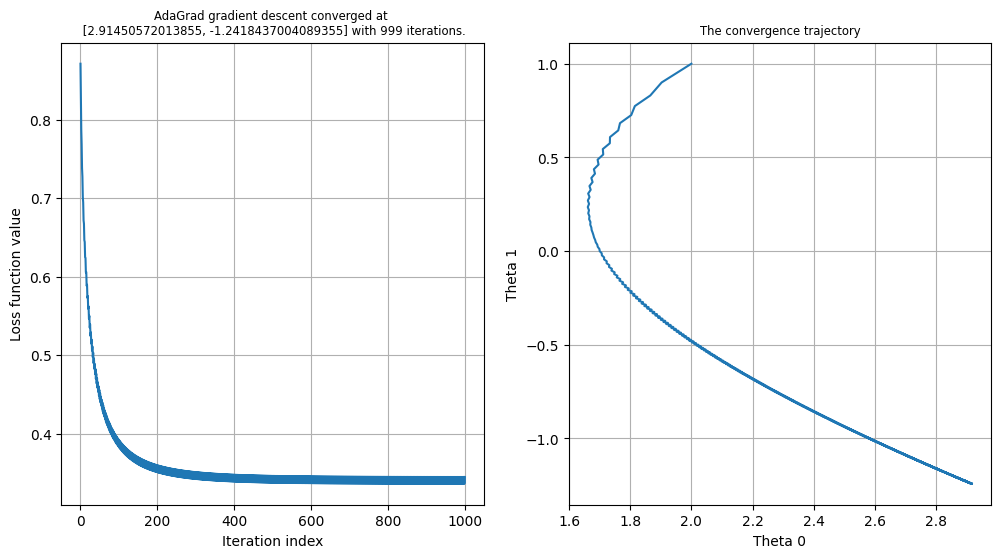

In [24]:
eps = 0.001 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.1]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $

loss_hist_adagrad = []
theta_adagrad_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_adagrad = theta.detach().clone()

BATCH_SIZE = 25

size = y.size(0)
num_batches = math.ceil(size / BATCH_SIZE)
G = torch.zeros_like(theta_adagrad)

for epoch in range(max_epoch):
  i = epoch % num_batches

  x_mgd, y_mgd = get_sample(i, BATCH_SIZE)
  loss = mgd_loss_generator(x_mgd, y_mgd)

  loss_hist_adagrad.append(loss(theta_adagrad).detach().numpy().item())
  grad_val = grad_center(loss, theta_adagrad)

  G += grad_val**2

  theta_adagrad -= alpha * grad_val / torch.sqrt(G + 3e-6)

  theta_adagrad_hist = torch.cat((theta_adagrad_hist, torch.reshape(theta_adagrad, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_adagrad_hist[-1] - theta_adagrad_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_adagrad) + 1)), loss_hist_adagrad)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'AdaGrad gradient descent converged at \n {theta_adagrad.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_adagrad_hist[:, 0], theta_adagrad_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

### RMSProp

A serious drawback of the AdaGrad algorithm is and exponential decay of a learning rate $ \lambda $, due to the accumulation of the gradient values and uncontrollable growth in the denominator. On the one hand, rate decay results in reducing fluctuations in the objective function, but on the other hand, the rate becomes negligibly small after some iterations, so the algorithm may never reach the global minimum.

In the RMSProp (Root Mean Square Propagation) algorithm this issue is solved by using the mean value of gradients in the denominator from the previous iterations instead of constant accumulation:

$ E(g^{2})_{i} = \beta E(g^{2})_{i-1} + (1 - \beta) g_{i}^{2} $

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{E(g^{2})_{i} + \epsilon}} \odot g_{i} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a smoothing term, and $ \beta $ is a momentum term (according to the original research, the optimal value is 0.9

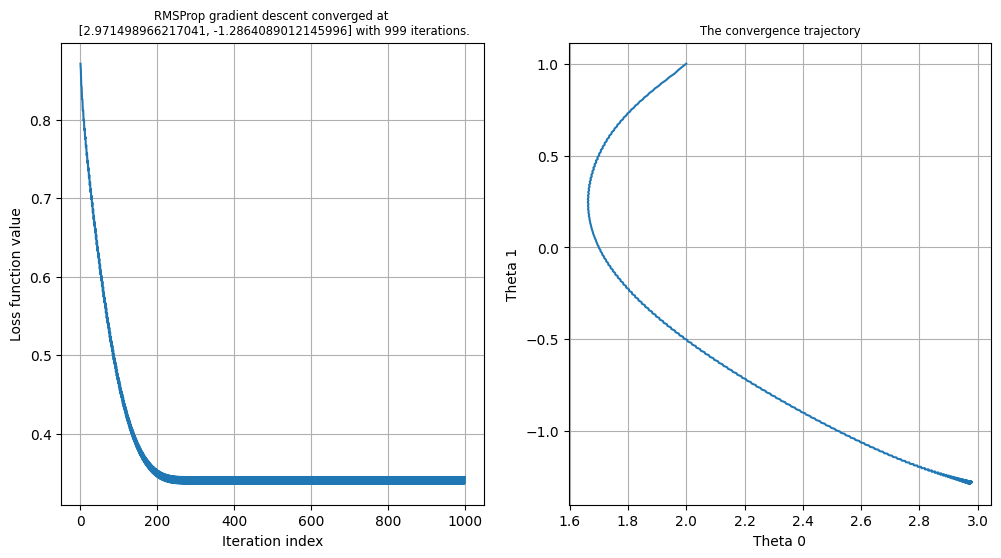

In [25]:
eps = 0.001 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1000
alpha = torch.tensor([0.01]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $
beta = torch.tensor([0.9]) # A momentum term

loss_hist_rmsprop = []
theta_rmsprop_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_rmsprop = theta.detach().clone()

BATCH_SIZE = 25

size = y.size(0)
num_batches = math.ceil(size / BATCH_SIZE)
G = torch.zeros_like(theta_rmsprop)

for epoch in range(max_epoch):
  i = epoch % num_batches

  x_mgd, y_mgd = get_sample(i, BATCH_SIZE)
  loss = mgd_loss_generator(x_mgd, y_mgd)

  loss_hist_rmsprop.append(loss(theta_rmsprop).detach().numpy().item())
  grad_val = grad_center(loss, theta_rmsprop)

  G = beta * G + (1 - beta) * grad_val**2

  theta_rmsprop -= alpha * grad_val / torch.sqrt(G + 3e-6)

  theta_rmsprop_hist = torch.cat((theta_rmsprop_hist, torch.reshape(theta_rmsprop, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_rmsprop_hist[-1] - theta_rmsprop_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_rmsprop) + 1)), loss_hist_rmsprop)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'RMSProp gradient descent converged at \n {theta_rmsprop.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_rmsprop_hist[:, 0], theta_rmsprop_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

### ADAM

The ADAM (Adaptive Moment Estimation) algorithm adapts not only the learning rate $ \lambda $ to the parameters (like AdaGrad and RMSProp) also keeps an exponentially decaying average of past gradients $ m_{i} $, similar to momentum:

$ m_{i} = \beta_{1} m_{i-1} + (1 - \beta_{1}) g_{i} $

$ v_{i} = \beta_{2} v_{i-1} + (1 - \beta_{2}) g_{i}^{2} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ m_{i} $ - mean value estimation (first moment) of the gradients respectively, $ v_{i} $ - the uncentered variance estimation (second moment) of the gradients respectively.

The original research was shown, that moment estimations are biased towards zero on the first iterations, especially when terms $ \beta_{1} $, $ \beta_{2} $ are small. So in the descent algorithm, bias-corrected estimates are used:

$ \hat{m_{i}} = \frac{m_{i}}{1 - \beta_{1}} $

$ \hat{v_{i}} = \frac{v_{i}}{1 - \beta_{2}} $

Now update rule for parameters can be modified using adaptive estimations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{\hat{v_{i}} + \epsilon}} \hat{m_{i}} $

From the empirical point of view, default estimation terms for the algorithm are equal: $ \beta_{1} = 0.9 $, $ \beta_{2} = 0.999 $.

For the given optimization problem, the approach with adaptive estimations for learning rate $ \lambda $ and for momentum will result in not only efficient convergence on the sparse data but also in adaptive decay of the momentum when the algorithm is approaching the minimum point (so the algorithm will not jump over the minimum, unlike pure momentum algorithm).

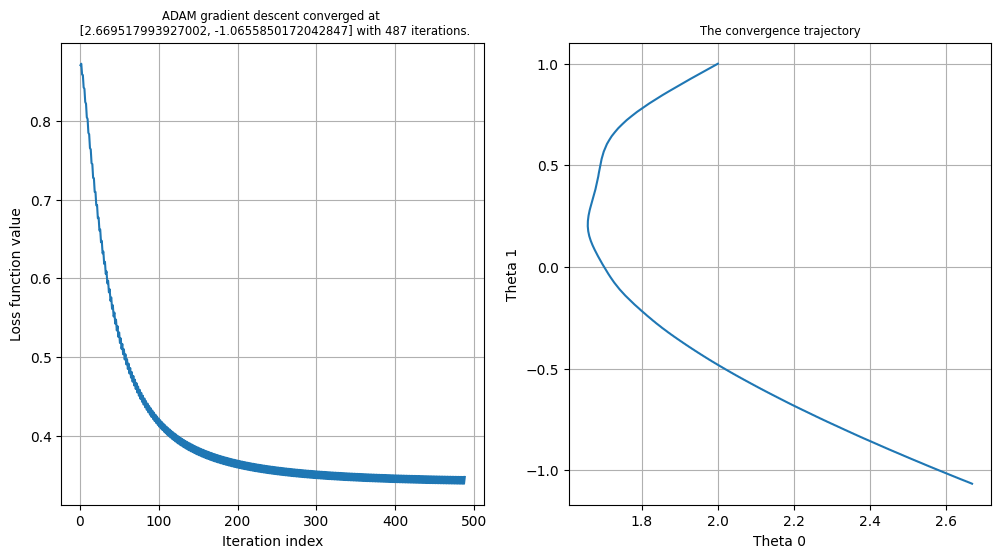

In [26]:
eps = 1e-3 # A numerical accuracy parameter: $ | x_i - x_{i-1} | < \varepsilon $
h = 0.0001 # A step of the derivative partitioning grid with the range of $ 0<h<1 $. The lower value, the higher gradient precision
epoch, max_epoch = 0, 1_000
alpha = torch.tensor([0.01]) # A gradient descent step with a valid range of $ 0 < \lambda < 1 $
beta1 = torch.tensor([0.9]) # A momentum term for the mean value
beta2 = torch.tensor([0.999]) # A momentum term for the variance value

loss_hist_adam = []
theta_adam_hist = torch.reshape(theta.detach().clone(), (1, theta.shape[0]))
theta_adam = theta.detach().clone()

BATCH_SIZE = 25

size = y.size(0)
num_batches = math.ceil(size / BATCH_SIZE)

mi = torch.zeros_like(theta_adam)
vi = torch.zeros_like(theta_adam)

for epoch in range(max_epoch):
  i = epoch % num_batches

  x_mgd, y_mgd = get_sample(i, BATCH_SIZE)
  loss = mgd_loss_generator(x_mgd, y_mgd)

  loss_hist_adam.append(loss(theta_adam).detach().numpy().item())
  grad_val = grad_center(loss, theta_adam)

  mi = beta1 * mi + (1 - beta1) * grad_val
  vi = beta2 * vi + (1 - beta2) * grad_val**2

  mi_hat = mi / (1 - beta1)
  vi_hat = vi / (1 - beta2)

  theta_adam -= alpha * mi_hat / torch.sqrt(vi_hat + 3e-6)

  theta_adam_hist = torch.cat((theta_adam_hist, torch.reshape(theta_adam, (1, theta.shape[0]))), dim=0)

  if torch.norm(theta_adam_hist[-1] - theta_adam_hist[-2]) < eps:
    break

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(list(range(1, len(loss_hist_adam) + 1)), loss_hist_adam)
axs[0].set_xlabel('Iteration index')
axs[0].set_ylabel('Loss function value')
axs[0].set_title(f'ADAM gradient descent converged at \n {theta_adam.detach().numpy().tolist()} with {epoch} iterations.',
                 fontdict={ 'fontsize': 'small' })
axs[0].grid(True)

axs[1].plot(theta_adam_hist[:, 0], theta_adam_hist[:, 1])
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].set_title('The convergence trajectory', fontdict={ 'fontsize': 'small' }) # TODO: add surface plot of the objective function
axs[1].grid(True)

plt.show()

## Conclusion

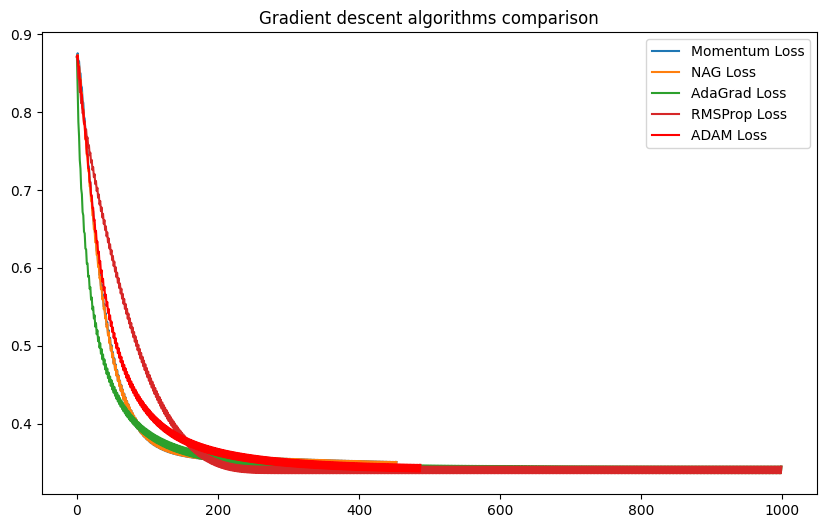

In [27]:
fig = plt.figure(figsize=(10, 6))

plt.plot(loss_hist_momentum, label='Momentum Loss')
plt.plot(loss_hist_nag, label='NAG Loss')
plt.plot(loss_hist_adagrad, label='AdaGrad Loss')
plt.plot(loss_hist_rmsprop, label='RMSProp Loss')
plt.plot(loss_hist_adam, 'r', label='ADAM Loss')
plt.title('Gradient descent algorithms comparison')
plt.legend()
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


def estimate(y_pred):
  return math.sqrt(mean_squared_error(y, y_pred))


def gd_estimate(theta):
  y_pred = converter_fn(adder_fn(theta, x))
  return estimate(y_pred)


lr = LogisticRegression()
lr.fit(x.T, y)
lr_estimate = lr.predict_proba(x.T)[:, 1]

lr_score = estimate(lr_estimate)

bgd_score = gd_estimate(theta_bgd)
sgd_score = gd_estimate(theta_sgd)
mgd_score = gd_estimate(theta_mgd)

momentum_score = gd_estimate(theta_momentum)
nag_score = gd_estimate(theta_nag)

adagrad_score = gd_estimate(theta_adagrad)
rmsprop_score = gd_estimate(theta_rmsprop)
adam_score = gd_estimate(theta_adam)

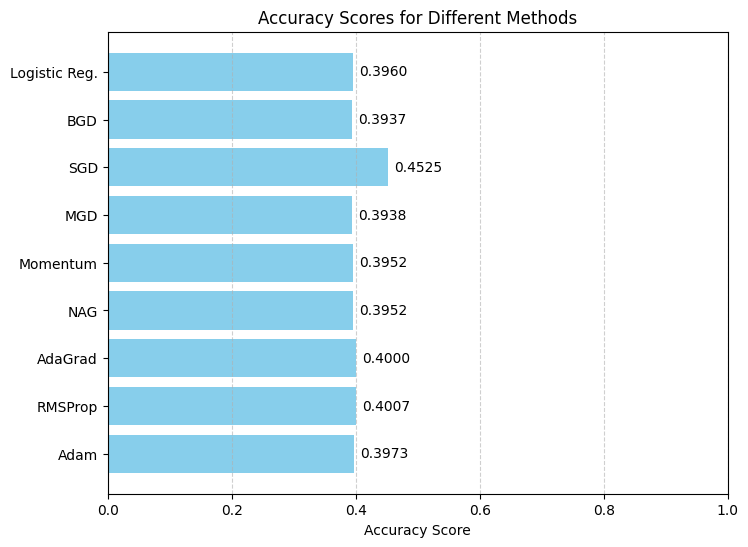

In [30]:
import matplotlib.pyplot as plt

# List of accuracy scores
accuracy_scores = [lr_score, bgd_score, sgd_score, mgd_score, momentum_score, nag_score, adagrad_score, rmsprop_score, adam_score]

# Corresponding labels or methods
methods = ['Logistic Reg.', 'BGD', 'SGD', 'MGD', 'Momentum', 'NAG', 'AdaGrad', 'RMSProp', 'Adam']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.barh(methods, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores for Different Methods')
plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1 for accuracy scores
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest accuracy at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the values on the bars
for i, score in enumerate(accuracy_scores):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.show()